In [21]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score,f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob


In [3]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Path to the dataset folder
dataset_path = "C:\\Users\\Student\\Desktop\\bd\\Dataset_BUSI_with_GT"  # Replace with your actual path

# Function to load images and labels
def load_dataset(dataset_path, img_size=(128, 128)):
    images = []
    labels = []
    
    categories = ['benign', 'malignant', 'normal']
    
    for category in categories:
        image_paths = glob(os.path.join(dataset_path, category, f"{category} (*).png"))
        image_paths = [p for p in image_paths if not p.endswith('_mask.png')]
        
        for img_path in image_paths:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            images.append(img)
            labels.append(category)
    
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

In [26]:
# Function to print confusion matrix and metrics
def evaluate_model(model_name, y_true, y_pred, class_names):
    print(f"\n--- {model_name} ---")
 
 # Debugging: Check shapes and values
    print(f"y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")
    print(f"Unique true labels: {np.unique(y_true)}")
    print(f"Unique predicted labels: {np.unique(y_pred)}")

 # Accuracy
    acc = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

 # Precision, Recall, F1-Score (Macro-averaged)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print("Precision (macro):", precision)
    print("Recall (macro):", recall)
    print("F1-Score (macro):", f1)
     # Classification Report (for per-class metrics)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # Numerical Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix (Numerical):")
    print(f"{'':>12} {'Predicted':>30}")
    print(f"{'':>12} {' '.join(f'{name:>8}' for name in class_names)}")
    for i, row in enumerate(cm):
        print(f"{class_names[i]:>12} {' '.join(f'{val:>8}' for val in row)}")
    
    # Visual Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    # Load dataset
IMG_SIZE = (128, 128)
images, labels = load_dataset(dataset_path, IMG_SIZE)
print(f"Loaded {len(images)} images with shape {images.shape}")

Loaded 780 images with shape (780, 128, 128)


In [27]:
# Main execution
def main():
    # Load dataset
    IMG_SIZE = (128, 128)
    images, labels = load_dataset(dataset_path, IMG_SIZE)
    print(f"Loaded {len(images)} images with shape {images.shape}")
    
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(labels)
class_names = le.classes_

# Normalize images for ML models
X_ml = images.reshape(len(images), -1) / 255.0  # Flatten and normalize
X_cnn = images[..., np.newaxis] / 255.0  # Add channel dimension for CNN

# Split dataset (80% train, 20% test)
X_train_ml, X_test_ml, y_train, y_test = train_test_split(
    X_ml, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
X_train_cnn, X_test_cnn = (
    X_train_ml.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1),
    X_test_ml.reshape(-1, IMG_SIZE[0], IMG_SIZE[1], 1)
)

print(f"Training samples: {len(X_train_ml)}, Testing samples: {len(X_test_ml)}")

Training samples: 624, Testing samples: 156



Training SVM...

--- SVM ---
Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

      benign       0.79      0.85      0.82        87
   malignant       0.70      0.74      0.72        42
      normal       0.67      0.44      0.53        27

    accuracy                           0.75       156
   macro avg       0.72      0.68      0.69       156
weighted avg       0.74      0.75      0.74       156


Confusion Matrix (Numerical):
                                  Predicted
               benign malignant   normal
      benign       74        8        5
   malignant       10       31        1
      normal       10        5       12


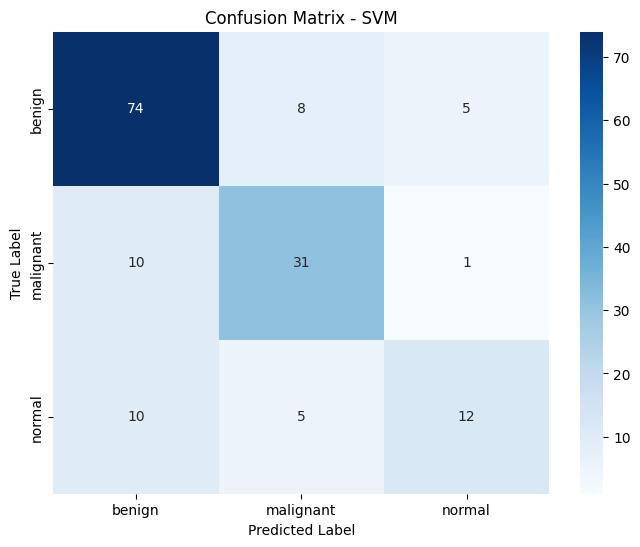

In [6]:
# 1. SVM
print("\nTraining SVM...")
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train_ml, y_train)
y_pred_svm = svm.predict(X_test_ml)
evaluate_model("SVM", y_test, y_pred_svm, class_names)


Training KNN...

--- KNN ---
Accuracy: 0.6346153846153846

Classification Report:
              precision    recall  f1-score   support

      benign       0.74      0.74      0.74        87
   malignant       0.56      0.64      0.60        42
      normal       0.38      0.30      0.33        27

    accuracy                           0.63       156
   macro avg       0.56      0.56      0.56       156
weighted avg       0.63      0.63      0.63       156


Confusion Matrix (Numerical):
                                  Predicted
               benign malignant   normal
      benign       64       14        9
   malignant       11       27        4
      normal       12        7        8


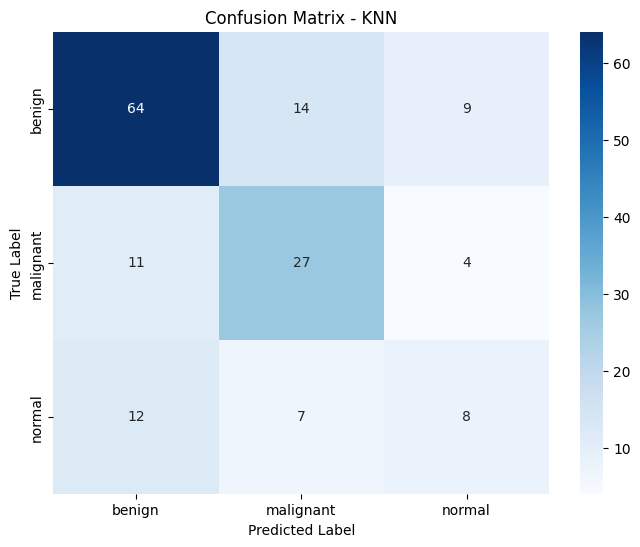

In [7]:
# 2. KNN
print("\nTraining KNN...")
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_ml, y_train)
y_pred_knn = knn.predict(X_test_ml)
evaluate_model("KNN", y_test, y_pred_knn, class_names)


Training Random Forest...

--- Random Forest ---
Accuracy: 0.7115384615384616

Classification Report:
              precision    recall  f1-score   support

      benign       0.68      0.91      0.78        87
   malignant       0.80      0.57      0.67        42
      normal       0.80      0.30      0.43        27

    accuracy                           0.71       156
   macro avg       0.76      0.59      0.63       156
weighted avg       0.73      0.71      0.69       156


Confusion Matrix (Numerical):
                                  Predicted
               benign malignant   normal
      benign       79        6        2
   malignant       18       24        0
      normal       19        0        8


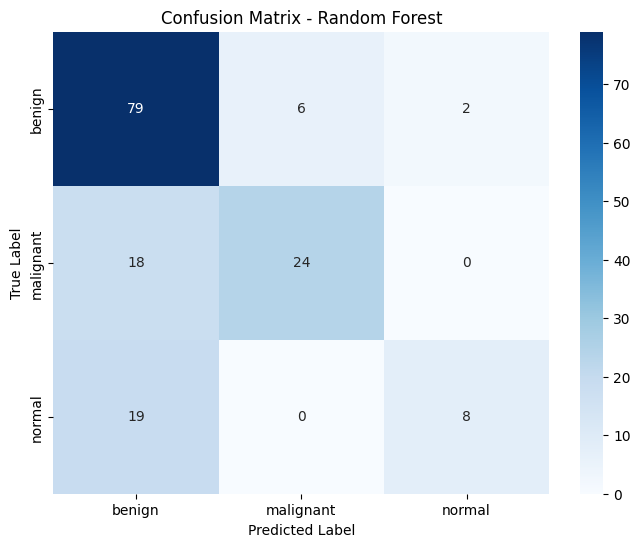

In [8]:
# 3. Random Forest
print("\nTraining Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_ml, y_train)
y_pred_rf = rf.predict(X_test_ml)
evaluate_model("Random Forest", y_test, y_pred_rf, class_names)



Training Logistic Regression...

--- Logistic Regression ---
Accuracy: 0.7692307692307693

Classification Report:
              precision    recall  f1-score   support

      benign       0.79      0.87      0.83        87
   malignant       0.70      0.74      0.72        42
      normal       0.81      0.48      0.60        27

    accuracy                           0.77       156
   macro avg       0.77      0.70      0.72       156
weighted avg       0.77      0.77      0.76       156


Confusion Matrix (Numerical):
                                  Predicted
               benign malignant   normal
      benign       76        9        2
   malignant       10       31        1
      normal       10        4       13


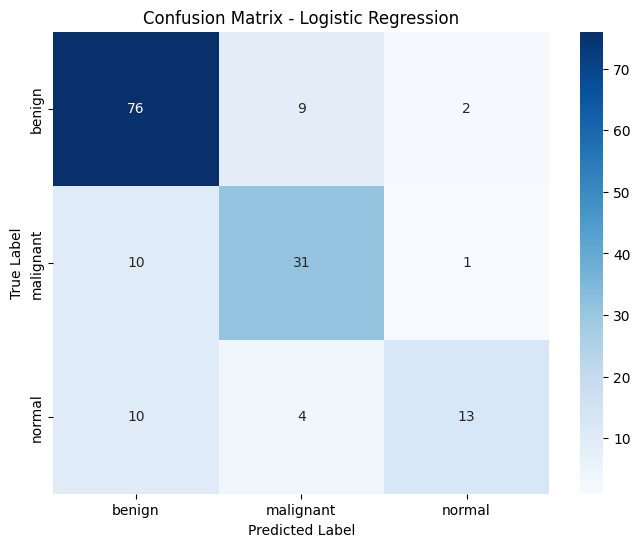

In [9]:
# 4. Logistic Regression
print("\nTraining Logistic Regression...")
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_ml, y_train)
y_pred_lr = lr.predict(X_test_ml)
evaluate_model("Logistic Regression", y_test, y_pred_lr, class_names)


In [32]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [33]:

# Create and compile the CNN model
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 1)
num_classes = len(class_names)
cnn_model = create_cnn_model(input_shape, num_classes)
cnn_model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])


C:\Users\Student\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
# Train the CNN model
history = cnn_model.fit(X_train_cnn, y_train, 
                        epochs=25, 
                        batch_size=32, 
                        validation_data=(X_test_cnn, y_test))

Epoch 1/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9968 - loss: 0.0033 - val_accuracy: 0.7692 - val_loss: 1.9189
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9983 - loss: 0.0057 - val_accuracy: 0.7692 - val_loss: 2.0978
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.7692 - val_loss: 2.2193
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9973 - loss: 0.0042 - val_accuracy: 0.7821 - val_loss: 2.3312
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9954 - loss: 0.0073 - val_accuracy: 0.7756 - val_loss: 2.5783
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.9934 - loss: 0.0175 - val_accuracy: 0.7949 - val_loss: 1.5965
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.9941 - loss: 0.0316 - val_accuracy: 0.7564 - val_loss: 2.8047
Epoch 8/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9910 - loss: 0.0290 - val_accuracy: 0.7692 - v

In [54]:
# Evaluate CNN model
y_pred_cnn_probs = cnn_model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step



--- CNN ---
y_true shape: (156,), y_pred shape: (156,)
Unique true labels: [0 1 2]
Unique predicted labels: [0 1 2]
Accuracy: 0.8012820512820513

Classification Report:
              precision    recall  f1-score   support

      benign       0.82      0.89      0.85        87
   malignant       0.73      0.76      0.74        42
      normal       0.89      0.59      0.71        27

    accuracy                           0.80       156
   macro avg       0.81      0.75      0.77       156
weighted avg       0.81      0.80      0.80       156

Precision (macro): 0.8117701841106096
Recall (macro): 0.7465182752539073
F1-Score (macro): 0.7687086289681689

Classification Report:
              precision    recall  f1-score   support

      benign       0.82      0.89      0.85        87
   malignant       0.73      0.76      0.74        42
      normal       0.89      0.59      0.71        27

    accuracy                           0.80       156
   macro avg       0.81      0.75      0.77

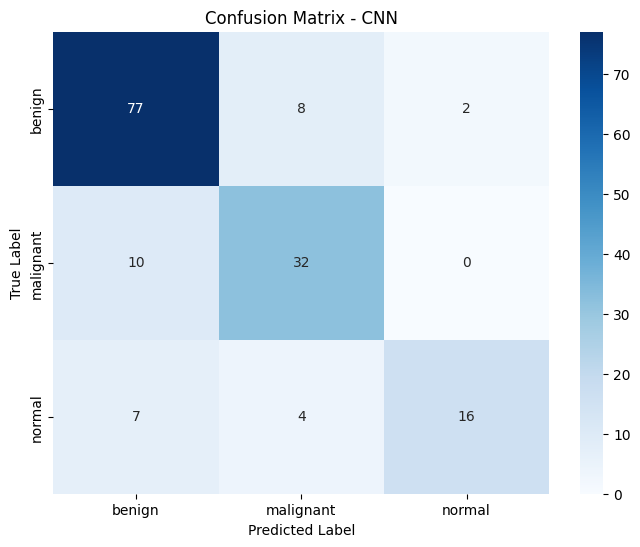

In [55]:
# Print evaluation metrics
evaluate_model("CNN", y_test, y_pred_cnn, class_names)

In [47]:
def main():
    # Load dataset
    IMG_SIZE = (128, 128)
    images, labels = load_dataset(dataset_path, IMG_SIZE)
    print(f"Loaded {len(images)} images with shape {images.shape}")
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(labels)
    class_names = le.classes_

    # Prepare data for CNN
    X_cnn = images[..., np.newaxis] / 255.0  # Add channel dimension and normalize

    # Split dataset
    X_train_cnn, X_test_cnn, y_train, y_test = train_test_split(
        X_cnn, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    print(f"Training samples: {len(X_train_cnn)}, Testing samples: {len(X_test_cnn)}")

    # Build CNN model
    cnn_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(class_names), activation='softmax')
    ])

    cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Callback to track test accuracy
    test_acc_callback = TestAccuracyCallback((X_test_cnn, y_test))

    # Train model
    history = cnn_model.fit(
        X_train_cnn, y_train,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[test_acc_callback],
        verbose=1
    )

    # Plot validation vs. test accuracy
    plot_val_and_test_accuracy(history, test_acc_callback.test_accuracies)

    # Predict and evaluate
    y_pred_cnn = cnn_model.predict(X_test_cnn)
    y_pred_cnn = np.argmax(y_pred_cnn, axis=1)
    evaluate_model("CNN", y_test, y_pred_cnn, class_names)


In [49]:
# Plot Validation Accuracy and Test Accuracy
def plot_val_and_test_accuracy(history, test_accuracies):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy', linestyle='--', marker='o')
    plt.title('Validation and Test Accuracy vs. Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
